In [2]:
import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# extract and open target files
target_path = Path("target")
target_initials = []
target_maps = []
target_indices = []
for target in target_path.iterdir():
    if target.stem.isnumeric():
        images = target.glob("*.png")
        for img in images:
            if "initial" in img.stem.lower():
                target_initials.append(cv.imread(img))
            elif "mapped" in img.stem.lower():
                target_maps.append(cv.imread(img))
        target_indices.append(int(target.stem))

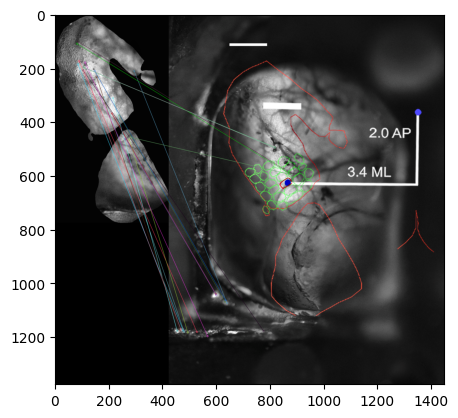

In [251]:
# using ORB

def extract_red(img, iterations=5):
    # isolate just red area
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    l1 = np.array([0, 100, 100])
    u1 = np.array([10, 255, 255])
    not_red = cv.inRange(img_hsv, l1, u1)
    
    l2 = np.array([150, 100, 100])
    u2 = np.array([180, 255, 255])
    red = cv.inRange(img_hsv, l2, u2)

    red_mask = cv.bitwise_or(not_red, red)

    # reduce noise and fill gaps
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    dilatation = cv.morphologyEx(red_mask, cv.MORPH_CLOSE, kernel, iterations=5)

    # approximate regions with contour detection
    cnt, _ = cv.findContours(dilatation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    blank = np.zeros_like(img)
    contours = cv.drawContours(blank, cnt, -1, (255,0,0), 3)
    
    return dilatation

def detect_with_orb(template, img, mapped_overlay, num_matches=50):
    # improve contrast
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    # extract keypoints from template
    *bgr, a = cv.split(template)
    template_bgr = cv.merge(bgr)
    template_gray = cv.cvtColor(template_bgr, cv.COLOR_BGR2GRAY)
    template_contrast = clahe.apply(template_gray)
    
    orb = cv.ORB_create(nfeatures=1000)
    kp_template, des_template = orb.detectAndCompute(
        template_contrast, 
        mask=a
    )
    
    # extract keypoints from img
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_contrast = clahe.apply(img_gray)
    kp_img, des_img = orb.detectAndCompute(img_contrast, None)

    # match
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_template,des_img)
    good = sorted(matches, key=lambda x: x.distance)

    # display matches
    mapped_lab = cv.cvtColor(mapped_overlay, cv.COLOR_BGR2LAB)
    lab_planes = list(cv.split(mapped_lab))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv.merge(lab_planes)
    mapped_contrast = cv.cvtColor(lab, cv.COLOR_LAB2RGB)
    match_img = cv.drawMatches(
        template_contrast, kp_template, 
        mapped_contrast, kp_img, 
        good[:num_matches], # Draw only the best 50 matches
        None, 
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # calculate transformation
    
    
    return match_img

template = cv.imread("template_665.png", cv.IMREAD_UNCHANGED)
target = 9
result = detect_with_orb(template, target_initials[target], target_maps[target], num_matches=20)
plt.imshow(result, cmap="grey")
plt.show()

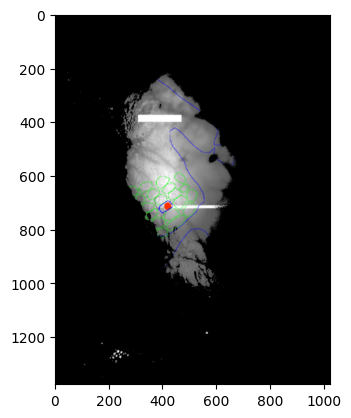

In [48]:
# simple thresholding

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
target = 5
gray = cv.cvtColor(target_initials[target], cv.COLOR_BGR2GRAY)
target_map = target_maps[target]
clahe_enhanced = clahe.apply(gray)
_,thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(cv.bitwise_and(target_map, target_map, mask=thresh), cmap="grey")
plt.show()

In [80]:
"""
Apply masks from .json files generated by labelme
"""

import os
import os.path as osp
import glob
import numpy as np
import PIL.Image

from labelme import utils
from labelme._label_file import LabelFile

INPUT_DIR = r"Target\annotation pairs"
OUTPUT_DIR = r"Target\dataset_split\region2"
TARGET_LABEL = "region2"

img_out_dir = osp.join(OUTPUT_DIR, "images")
mask_out_dir = osp.join(OUTPUT_DIR, "SegmentationClass")
os.makedirs(img_out_dir, exist_ok=True)
os.makedirs(mask_out_dir, exist_ok=True)

json_files = glob.glob(osp.join(INPUT_DIR, "*.json"))

print(f"Found {len(json_files)} .json files. Starting conversion...")

for json_file in json_files:
    label_file = LabelFile(filename=json_file)
    image = utils.img_data_to_arr(label_file.imageData)
    
    label_name_to_value = {"_background_": 0, TARGET_LABEL: 1}
    filtered_shapes = [s for s in label_file.shapes if s["label"] == TARGET_LABEL]
    
    lbl, _ = utils.shapes_to_label(
        image.shape, filtered_shapes, label_name_to_value
    )
    
    base = osp.splitext(osp.basename(json_file))[0]
    
    img_out_path = osp.join(img_out_dir, f"{base}.png")
    mask_out_path = osp.join(mask_out_dir, f"{base}.png")
    
    PIL.Image.fromarray(image).save(img_out_path)
    utils.lblsave(mask_out_path, lbl)

print(f"Conversion complete. Output saved to: {OUTPUT_DIR}")

Found 13 .json files. Starting conversion...
Conversion complete. Output saved to: Target\dataset_split\region2


In [121]:
"""
Vibe coded pytorch training
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Sampler
import copy
import ttach as tta

class RandomRepeatSampler(Sampler):
    """
    Samples elements randomly, with replacement, to reach a desired epoch length.
    
    Arguments:
        data_source (Dataset): dataset to sample from
        epoch_length (int): The number of samples to draw per epoch
    """
    def __init__(self, data_source, epoch_length):
        self.data_source = data_source
        self.epoch_length = epoch_length

    def __iter__(self):
        # Generate a list of random indices (with replacement)
        indices = torch.randint(high=len(self.data_source), 
                                size=(self.epoch_length,), 
                                dtype=torch.int64)
        return iter(indices.tolist())

    def __len__(self):
        return self.epoch_length

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, outputs, targets):
        dice_loss = self.dice_loss(outputs, targets)
        bce_loss = self.bce_loss(outputs, targets)
        
        # Combine the losses
        combined_loss = (self.dice_weight * dice_loss) + (self.bce_weight * bce_loss)
        return combined_loss

# Define transforms for training (with augmentation)
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomRotate90(p=0.8),
    A.Rotate(limit=360, p=0.7, border_mode=cv.BORDER_CONSTANT),
    #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, p=0.5, border_mode=cv.BORDER_CONSTANT, value=0),
    A.ElasticTransform(p=0.5, border_mode=cv.BORDER_CONSTANT),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet stats
    ToTensorV2(),
])

# Define transforms for validation (no augmentation)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

class BrainDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.images = sorted(self.image_dir.glob("*.png"))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx].name
        img_path = self.images[idx]
        mask_path = self.mask_dir / img_name # Assumes mask name matches image name

        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        
        mask[mask > 0] = 1.0 # Normalize mask to 0.0 or 1.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Add channel dim to mask: (H, W) -> (1, H, W)
        mask = mask.unsqueeze(0).float()

        return image, mask

def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs=25, name="best_model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    tta_transforms = tta.aliases.d4_transform()

    for epoch in range(num_epochs):
        model.train() # Training mode
        train_loss = 0.0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        # Validation
        model.eval() # Evaluation mode
        
        tta_model = tta.SegmentationTTAWrapper(model, tta_transforms, merge_mode='mean') # test-time augmentation
        tta_model.to(device)
        
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = tta_model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item() * images.size(0)

        avg_train_loss = train_loss / len(train_loader.sampler)
        avg_val_loss = val_loss / len(val_loader.dataset)

        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} \t Train Loss: {avg_train_loss:.6f} \t Val Loss: {avg_val_loss:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'{name}.pth')
            print(f"Model saved as {name}.pth")

    print("Training complete.")

TARGET_LABEL = "region2"
IMAGE_DIR = fr"Target\dataset_split\{TARGET_LABEL}\images"
MASK_DIR = fr"Target\dataset_split\{TARGET_LABEL}\SegmentationClass"

LEARNING_RATE = 0.001
BATCH_SIZE = 4
NUM_EPOCHS = 20 

full_dataset = BrainDataset(IMAGE_DIR, MASK_DIR, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset = copy.deepcopy(val_dataset.dataset)
val_dataset.dataset.transform = val_transform

train_epoch_length= 100
train_sampler = RandomRepeatSampler(train_dataset, train_epoch_length)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

loss_fn = CombinedLoss(dice_weight=0.5, bce_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs=NUM_EPOCHS, name=f"{TARGET_LABEL}_model")

Epoch 1/20 	 Train Loss: 0.621579 	 Val Loss: 0.496320
Model saved as region2_model.pth
Epoch 2/20 	 Train Loss: 0.415154 	 Val Loss: 0.321477
Model saved as region2_model.pth
Epoch 3/20 	 Train Loss: 0.287721 	 Val Loss: 0.204906
Model saved as region2_model.pth
Epoch 4/20 	 Train Loss: 0.225972 	 Val Loss: 0.242809
Epoch 5/20 	 Train Loss: 0.186638 	 Val Loss: 0.133455
Model saved as region2_model.pth
Epoch 6/20 	 Train Loss: 0.197337 	 Val Loss: 0.165331
Epoch 7/20 	 Train Loss: 0.211325 	 Val Loss: 0.117152
Model saved as region2_model.pth
Epoch 8/20 	 Train Loss: 0.175416 	 Val Loss: 0.144450
Epoch 9/20 	 Train Loss: 0.146640 	 Val Loss: 0.118918
Epoch 10/20 	 Train Loss: 0.134323 	 Val Loss: 0.136151
Epoch 11/20 	 Train Loss: 0.140513 	 Val Loss: 0.129388
Epoch 12/20 	 Train Loss: 0.132997 	 Val Loss: 0.136032
Epoch 13/20 	 Train Loss: 0.122471 	 Val Loss: 0.110789
Model saved as region2_model.pth
Epoch 14/20 	 Train Loss: 0.112489 	 Val Loss: 0.124195
Epoch 15/20 	 Train Loss: 0

C:\Users\Nolan\AppData\Local\Temp\ipykernel_13272\2019148288.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

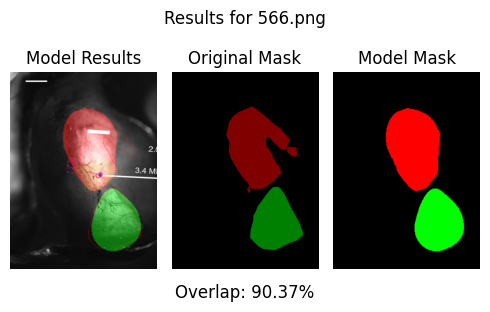

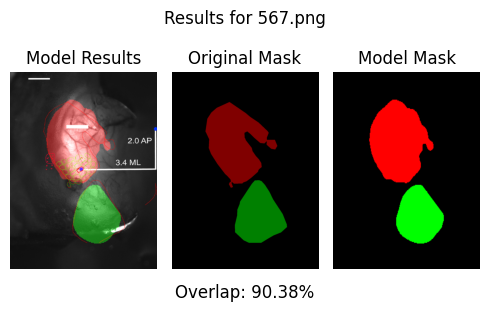

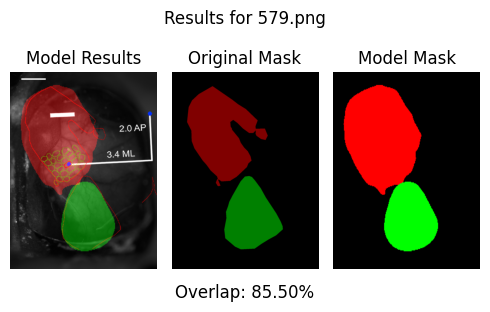

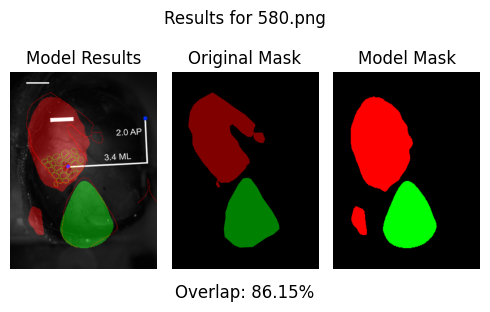

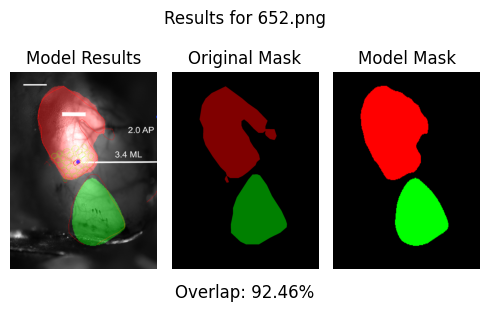

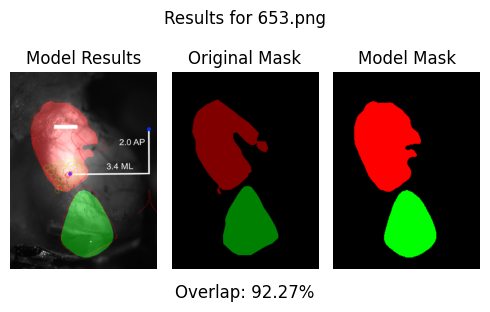

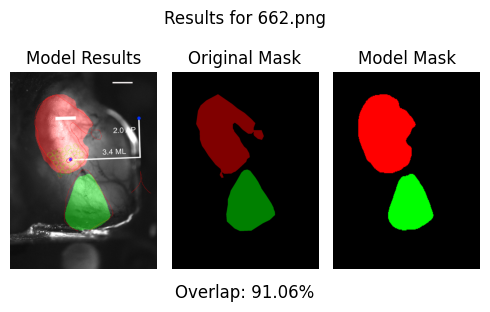

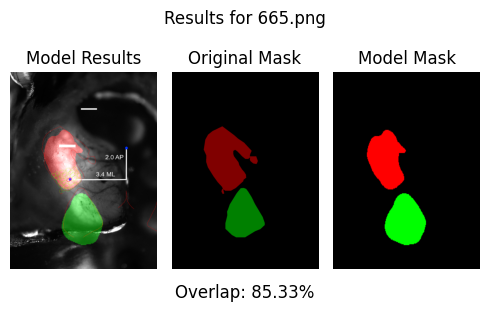

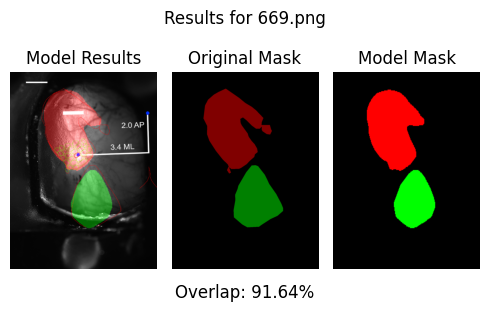

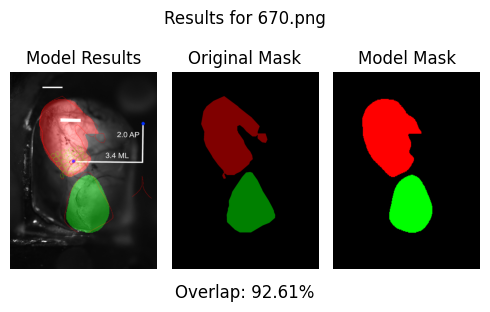

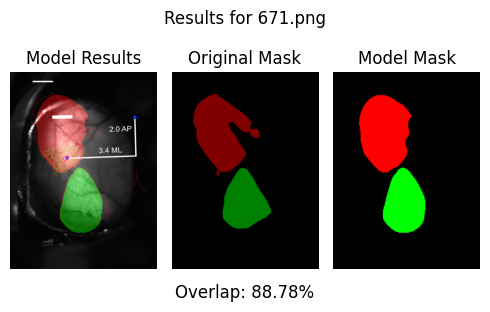

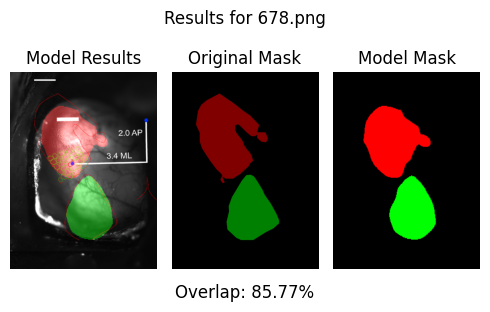

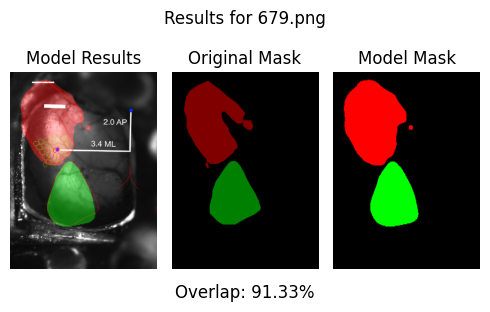

In [124]:
def calculate_dice_score(pred_mask, true_mask):
    pred_mask = (pred_mask > 0).astype(np.uint8)
    true_mask = (true_mask > 0).astype(np.uint8)
    intersection = np.sum(pred_mask * true_mask)
    total_pred = np.sum(pred_mask)
    total_true = np.sum(true_mask)
    epsilon = 1e-6

    dice = (2. * intersection + epsilon) / (total_pred + total_true + epsilon)
    return dice

def run_model(model_path, image_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        logits = model(image_tensor)
        probs = torch.sigmoid(logits)
        mask = (probs > 0.5).float().cpu().numpy().squeeze()
    
    return mask

for target in range(len(target_indices)):
    evaluation_image = cv.cvtColor(target_initials[target], cv.COLOR_BGR2RGB)
    #evaluation_image = cv.rotate(evaluation_image, cv.ROTATE_90_CLOCKWISE)
    mapped_image = cv.cvtColor(target_maps[target], cv.COLOR_BGR2RGB)
    #mapped_image = cv.rotate(mapped_image, cv.ROTATE_90_CLOCKWISE)
    eval_augmented = val_transform(image=evaluation_image)
    image_tensor = eval_augmented['image'].unsqueeze(0)

    h, w = evaluation_image.shape[:2]
    region1_mask = run_model(r"region1_model.pth", image_tensor)
    r1_resized = cv.resize(region1_mask, (w, h), interpolation=cv.INTER_NEAREST)
    overlay_r1 = np.zeros_like(evaluation_image, dtype=np.uint8)
    overlay_r1[r1_resized == 1] = (255, 0, 0)
    
    region2_mask = run_model(r"region2_model.pth", image_tensor)
    r2_resized = cv.resize(region2_mask, (w, h), interpolation=cv.INTER_NEAREST)
    overlay_r2 = np.zeros_like(evaluation_image, dtype=np.uint8)
    overlay_r2[r2_resized == 1] = (0, 255, 0)

    combined = np.zeros((h, w), dtype=image.dtype)
    combined[r1_resized == 1] = 255
    combined[r2_resized == 1] = 255

    combined_rgb = np.zeros_like(evaluation_image, dtype=np.uint8)
    combined_rgb[r1_resized == 1] = (255, 0, 0)
    combined_rgb[r2_resized == 1] = (0, 255, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(5, 3))

    combined_overlay = cv.addWeighted(mapped_image, 1, overlay_r1, 0.4, 0)
    combined_overlay = cv.addWeighted(combined_overlay, 1, overlay_r2, 0.4, 0)
    axes[0].imshow(combined_overlay)
    axes[0].set_title(f"Model Results")
    axes[0].axis("off")

    original_mask_path = rf"Target\dataset\SegmentationClass\annot_{target_indices[target]}.png"
    original_mask = cv.cvtColor(cv.imread(original_mask_path), cv.COLOR_BGR2RGB)
    #original_mask = cv.rotate(original_mask, cv.ROTATE_90_CLOCKWISE)
    axes[1].imshow(original_mask)
    axes[1].set_title(f"Original Mask")
    axes[1].axis("off")

    axes[2].imshow(combined_rgb)
    axes[2].set_title(f"Model Mask")
    axes[2].axis("off")

    plt.suptitle(f'Results for {target_indices[target]}.png')
    dice_score = calculate_dice_score(combined, cv.cvtColor(original_mask, cv.COLOR_RGB2GRAY))
    fig.text(0.5, 0.02, f'Overlap: {dice_score*100:.2f}%', ha='center', fontsize=12)
    plt.tight_layout()
    #plt.savefig(f'{target_indices[target]}_result.png', dpi=400)
    plt.show()

C:\Users\Nolan\AppData\Local\Temp\ipykernel_13272\96857972.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

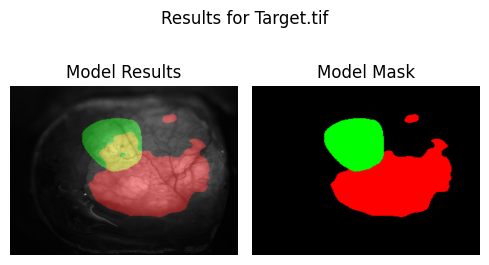

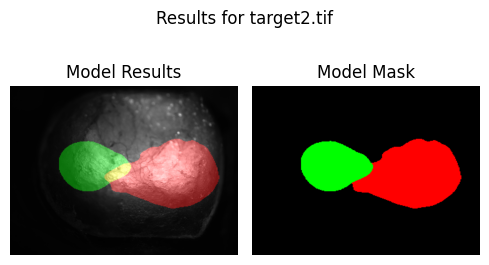

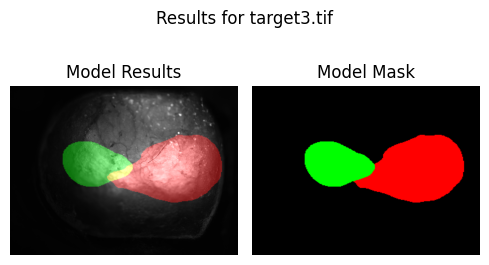

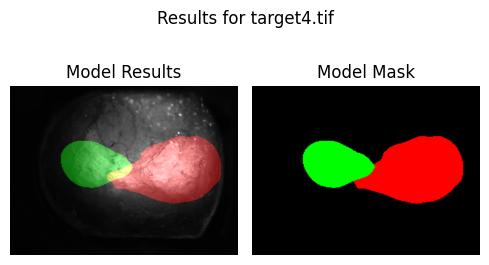

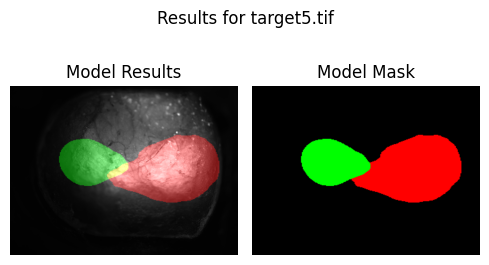

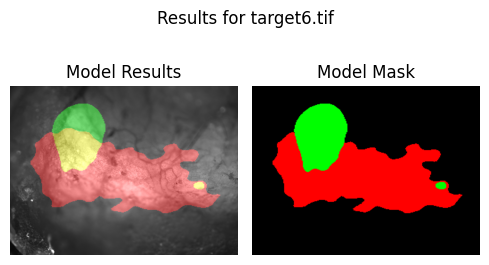

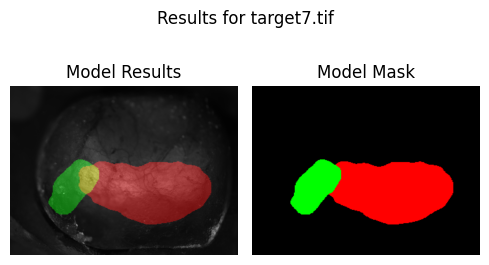

In [123]:
"""
For images without maps
"""

data_path = Path("11-12-2025_data")

for img in data_path.glob("*tif"):
    evaluation_image = cv.cvtColor(cv.imread(img), cv.COLOR_BGR2RGB)
    #evaluation_image = cv.rotate(evaluation_image, cv.ROTATE_90_CLOCKWISE)
    eval_augmented = val_transform(image=evaluation_image)
    image_tensor = eval_augmented['image'].unsqueeze(0)
    
    h, w = evaluation_image.shape[:2]
    region1_mask = run_model(r"region1_model.pth", image_tensor)
    r1_resized = cv.resize(region1_mask, (w, h), interpolation=cv.INTER_NEAREST)
    overlay_r1 = np.zeros_like(evaluation_image, dtype=np.uint8)
    overlay_r1[r1_resized == 1] = (255, 0, 0)
    
    region2_mask = run_model(r"region2_model.pth", image_tensor)
    r2_resized = cv.resize(region2_mask, (w, h), interpolation=cv.INTER_NEAREST)
    overlay_r2 = np.zeros_like(evaluation_image, dtype=np.uint8)
    overlay_r2[r2_resized == 1] = (0, 255, 0)

    combined = np.zeros((h, w), dtype=image.dtype)
    combined[r1_resized == 1] = 255
    combined[r2_resized == 1] = 255

    combined_rgb = np.zeros_like(evaluation_image, dtype=np.uint8)
    combined_rgb[r1_resized == 1] = (255, 0, 0)
    combined_rgb[r2_resized == 1] = (0, 255, 0)
    
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))
    
    h, w = evaluation_image.shape[:2]
    mask_resized = cv.resize(mask, (w, h), interpolation=cv.INTER_NEAREST)
    overlay = np.zeros_like(evaluation_image, dtype=np.uint8)
    overlay[mask_resized == 1] = (255, 0, 0)
    
    combined_overlay = cv.addWeighted(evaluation_image, 1, overlay_r1, 0.4, 0)
    combined_overlay = cv.addWeighted(combined_overlay, 1, overlay_r2, 0.4, 0)
    axes[0].imshow(combined_overlay)
    axes[0].set_title(f"Model Results")
    axes[0].axis("off")

    axes[1].imshow(combined_rgb)
    axes[1].set_title(f"Model Mask")
    axes[1].axis("off")

    plt.suptitle(f'Results for {img.name}')
    plt.tight_layout()
    #plt.savefig(f'{target_indices[target]}_result.png', dpi=400)
    plt.show()